### 1. Importing Libraries and Modules

In [38]:
import os
import json
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch

from utils.mnist_loader import MNISTLoader
from models.gan import GAN
from models.dcgan import DCGAN

### 2. Loading MNIST Dataset and Training Results

In [26]:
gan_model_names = ["gan", "dcgan"]
with open("config.json") as f:
    config = json.load(f)

loader = MNISTLoader()

# ckpt_path = ".ckpts/%s/" % gan_model_names[0]
# with open(ckpt_path + "results.pkl", "rb") as f:
#     generator_loss_mean, discriminator_loss_mean, gs = pickle.load(f)

### 3. Ploting the Generator and Discriminator Losses

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

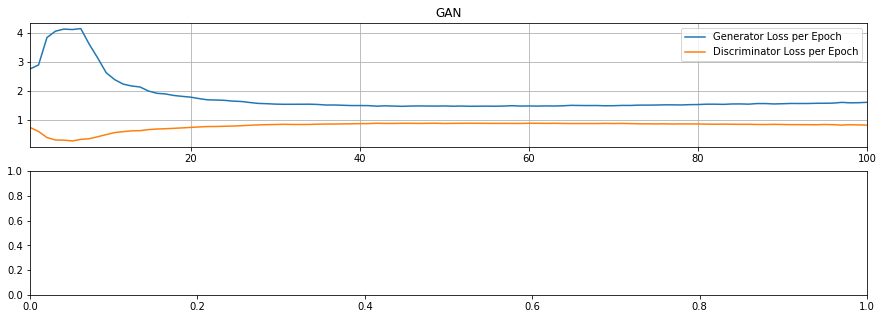

In [36]:
num_models = len(gan_model_names)
fig, axs = plt.subplots(nrows=num_models, figsize=[15, 5], facecolor="white")

for i, model_name in enumerate(gan_model_names):
    ckpt_path = ".ckpts/%s/" % model_name
    with open(ckpt_path + "results.pkl", "rb") as f:
        generator_loss_mean, discriminator_loss_mean, _ = pickle.load(f)
    axs[i].plot(t, generator_loss_mean, label="Generator Loss per Epoch")
    axs[i].plot(t, discriminator_loss_mean, label="Discriminator Loss per Epoch")
    axs[i].set_title(model_name.upper())
    axs[i].set_xlim(t[0], t[-1])
    axs[i].grid()
    axs[i].legend()

# t = np.arange(1, len(generator_loss_mean)+1)
# plt.figure(figsize=[15, 3], facecolor="white")
# plt.plot(t, generator_loss_mean, label="Generator Loss per Epoch")
# plt.plot(t, discriminator_loss_mean, label="Discriminator Loss per Epoch")
# plt.xlim(t[0], t[-1])
# plt.grid()
# plt.legend()
# plt.show()

### 4. Image Generation Results

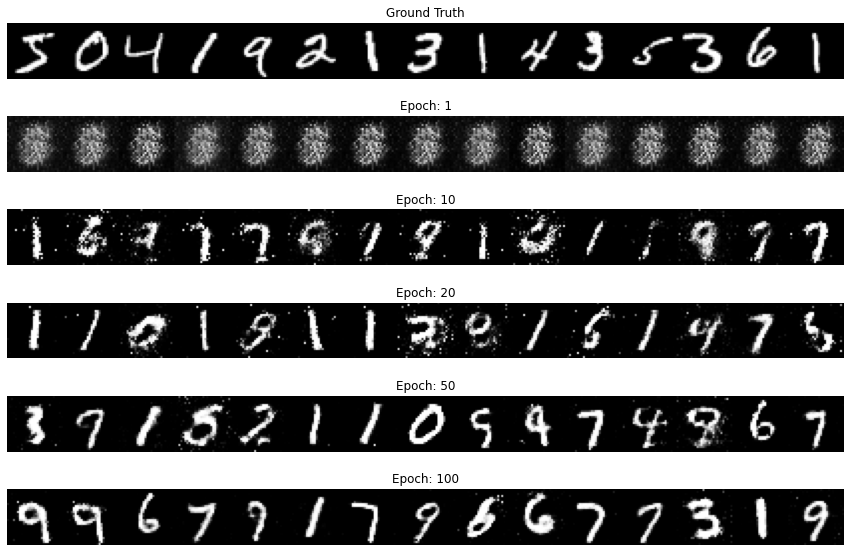

In [20]:
view_list = [1, 10, 20, 50, 100]
view_range = 15 # Should be less than conf.BATCH_SIZE

fig, axs = plt.subplots(nrows=1+len(view_list), figsize=[view_range, 10], facecolor="white")
axs[0].imshow(np.hstack(np.reshape(loader.train_features[:view_range], newshape=[view_range]+loader.feature_shape)), cmap="gray")
axs[0].set_title("Ground Truth")
axs[0].axis("off")

for i, idx in enumerate(view_list, 1):
    g = gs[idx-1].detach().numpy()
    axs[i].imshow(np.hstack(np.reshape(g[:view_range], newshape=[view_range]+loader.feature_shape)), cmap="gray")
    axs[i].set_title("Epoch: %i" % idx)
    axs[i].axis("off")
    
plt.savefig(ckpt_path + "image_generation_results.png")

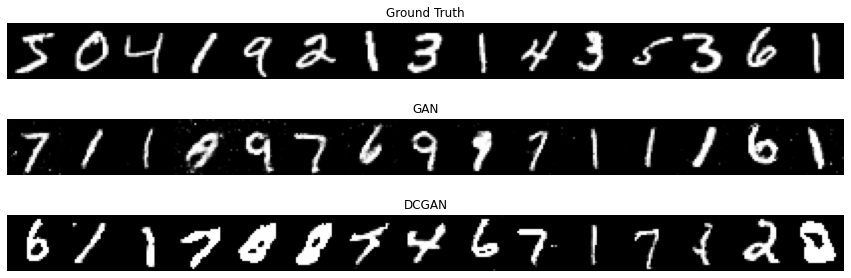

In [52]:
device = torch.device("cpu")

view_range = 15 # Should be less than conf.BATCH_SIZE
num_models = len(gan_model_names)

fig, axs = plt.subplots(nrows=1+num_models, figsize=[view_range, 5], facecolor="white")
axs[0].imshow(np.hstack(np.reshape(loader.train_features[:view_range], newshape=[view_range]+loader.feature_shape)), cmap="gray")
axs[0].set_title("Ground Truth")
axs[0].axis("off")

for i, model_name in enumerate(gan_model_names, 1):
    ckpt_path = ".ckpts/%s/" % model_name
    
    if model_name == "gan":
        model = GAN(loader.feature_depth, config[model_name]["latent_depth"], False)
    elif model_name == "dcgan":
        model = DCGAN(loader.feature_shape, config[model_name]["latent_depth"], False)
    
    model.generator.load_state_dict(torch.load(ckpt_path + "generator_100.ckpt", map_location=device))
    model.discriminator.load_state_dict(torch.load(ckpt_path + "discriminator_100.ckpt", map_location=device))
    
    model.generator.eval()
    
    noises = torch.tensor(np.random.normal(size=[view_range, config[model_name]["latent_depth"]])).float()
    generated_images = model.generator(noises).detach().numpy()
    
    axs[i].imshow(np.hstack(np.reshape(generated_images, newshape=[view_range]+loader.feature_shape)), cmap="gray")
    axs[i].set_title(model_name.upper())
    axs[i].axis("off")
    
# plt.savefig(ckpt_path + "image_generation_results.png")

### 5. Loading Checkpoint

In [5]:
model = GAN(loader.feature_depth, config[gan_model_names[0]]["latent_depth"])

model.generator.load_state_dict(torch.load(ckpt_path + "generator_100.ckpt"))
model.discriminator.load_state_dict(torch.load(ckpt_path + "discriminator_100.ckpt"))

<All keys matched successfully>

In [6]:
model.generator.eval()

Sequential(
  (linear0): Linear(in_features=20, out_features=128, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (linear3): Linear(in_features=256, out_features=784, bias=True)
  (act3): Tanh()
)

In [7]:
model.discriminator.eval()

Sequential(
  (linear0): Linear(in_features=784, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (linear1): Linear(in_features=256, out_features=256, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
)

### 6. Random Image Generation

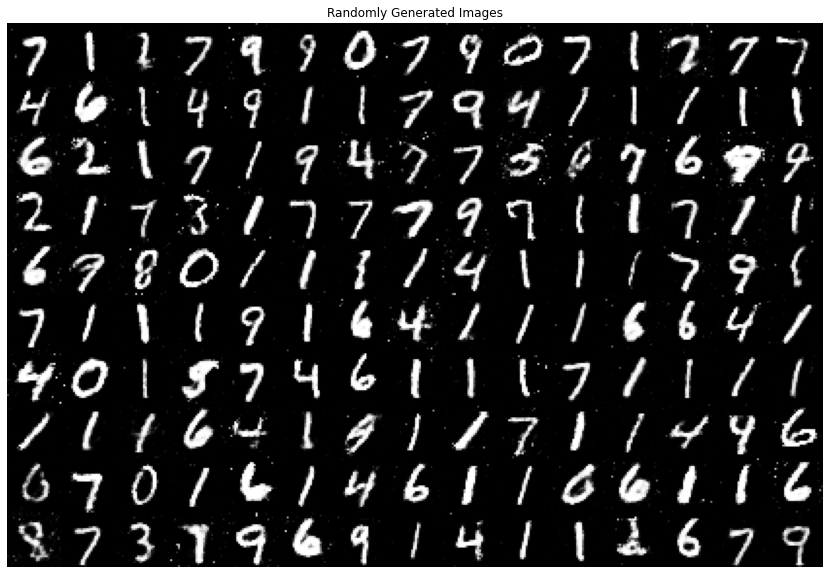

In [8]:
noises = torch.tensor(np.random.normal(size=[150, config[gan_model_names[0]]["latent_depth"]])).float()
generated_images = model.generator(noises).detach().numpy()

plt.figure(figsize=[15, 10], facecolor="white")
plt.imshow(np.hstack(np.hstack(np.reshape(generated_images, newshape=[10, 15]+loader.feature_shape))), cmap="gray")
plt.axis("off")
plt.title("Randomly Generated Images")

plt.savefig(ckpt_path + "randomly_generated_images.png")
plt.savefig(ckpt_path + "noise_robustness_results.png")